In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import date
from statsmodels.tsa.stattools import adfuller


# Read in CSV
df = pd.read_csv('/content/data_daily.csv')
df['# Date'] = pd.to_datetime(df['# Date'])

In [142]:
print(df)

        # Date  Receipt_Count
0   2021-01-01        7564766
1   2021-01-02        7455524
2   2021-01-03        7095414
3   2021-01-04        7666163
4   2021-01-05        7771289
..         ...            ...
360 2021-12-27       10350408
361 2021-12-28       10219445
362 2021-12-29       10313337
363 2021-12-30       10310644
364 2021-12-31       10211187

[365 rows x 2 columns]


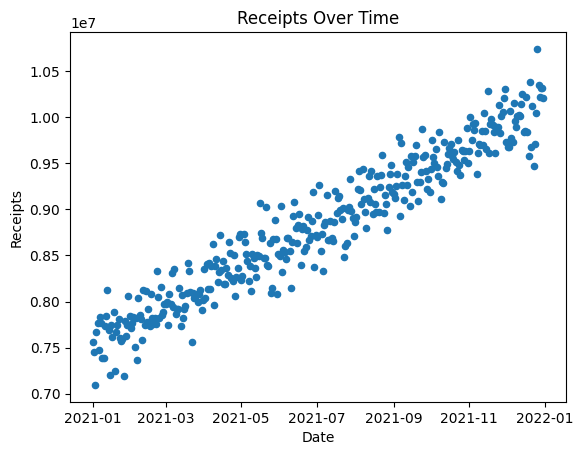

In [143]:
# Display Receipts with respect to Time
df.plot(x='# Date', y='Receipt_Count', kind='scatter')

plt.title('Receipts Over Time')
plt.xlabel('Date')
plt.ylabel('Receipts')
plt.show()

        # Date  Receipt_Count  Holiday_Match
0   2021-01-01        7564766           True
1   2021-01-02        7455524          False
2   2021-01-03        7095414          False
3   2021-01-04        7666163          False
4   2021-01-05        7771289          False
..         ...            ...            ...
360 2021-12-27       10350408          False
361 2021-12-28       10219445          False
362 2021-12-29       10313337          False
363 2021-12-30       10310644          False
364 2021-12-31       10211187           True

[365 rows x 3 columns]


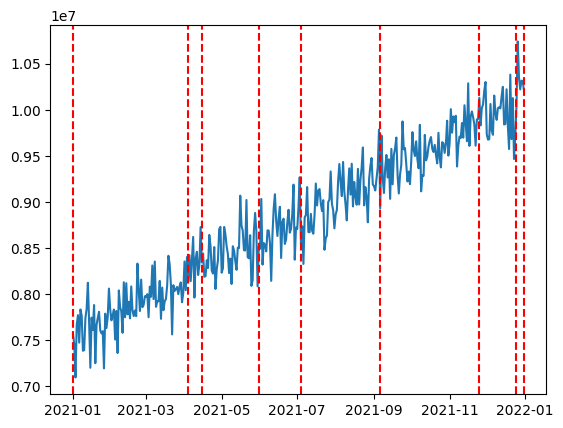

In [144]:
def is_holiday_in_month_day(row_date, holiday_list):
    row_month_day = (row_date.month, row_date.day)
    for holiday_date in holiday_list:
        if (holiday_date.month, holiday_date.day) == row_month_day:
            return True
    return False

holiday_dates = [
    date(2021, 1, 1), # New Years
    date(2021, 4, 4), # Easter
    date(2021, 4, 15), # Tax day
    date(2021, 5, 31), # Memorial Day
    date(2021, 7, 4), # Independence Day
    date(2021, 9, 6), # Labor Day
    date(2021, 11, 25), # Thanksgiving
    date(2021, 12, 25), # Christmas
    date(2021, 12, 31), # New Years Eve
]

df['Holiday_Match'] = df['# Date'].apply(lambda x: is_holiday_in_month_day(x, holiday_dates))

plt.plot(df['# Date'], df['Receipt_Count'], label='Sales')

print(df)

# Highlight holidays by marking them with red vertical lines
for holiday_date in df[df['Holiday_Match']]['# Date']:
    plt.axvline(holiday_date, color='red', linestyle='--')


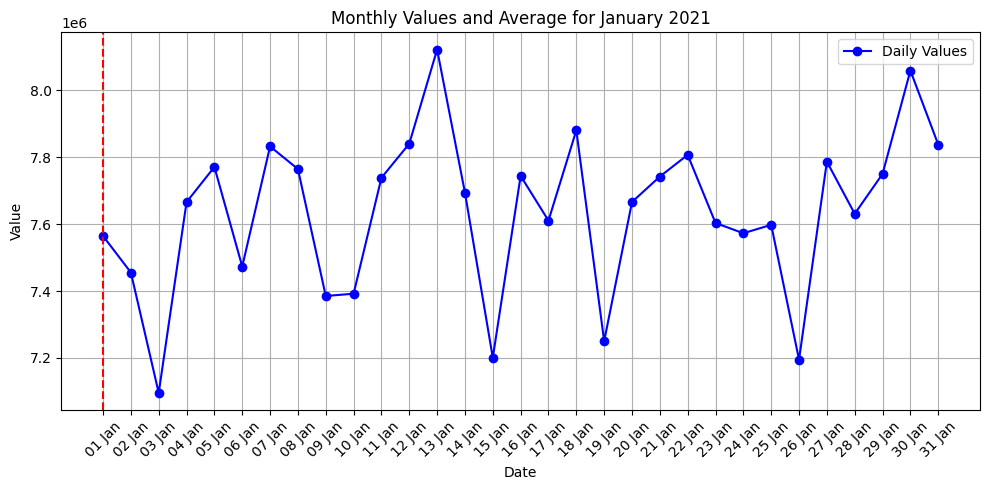

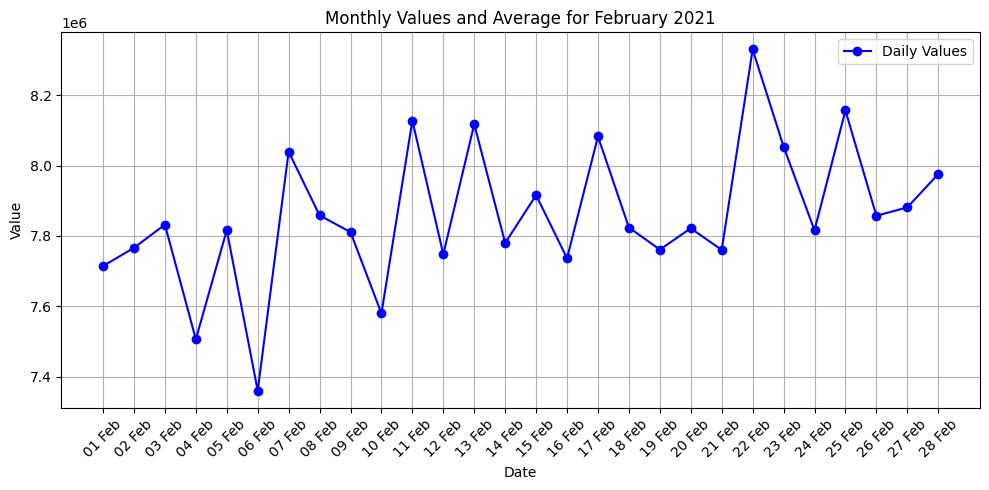

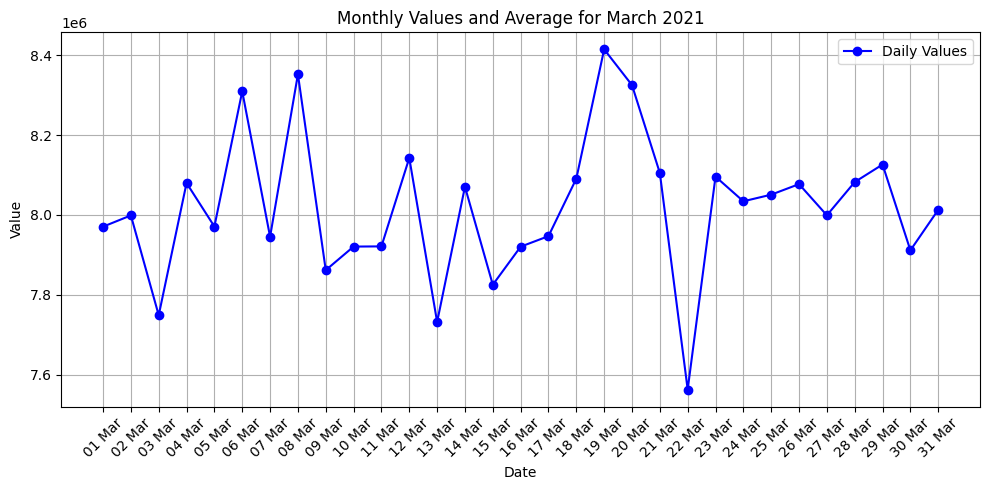

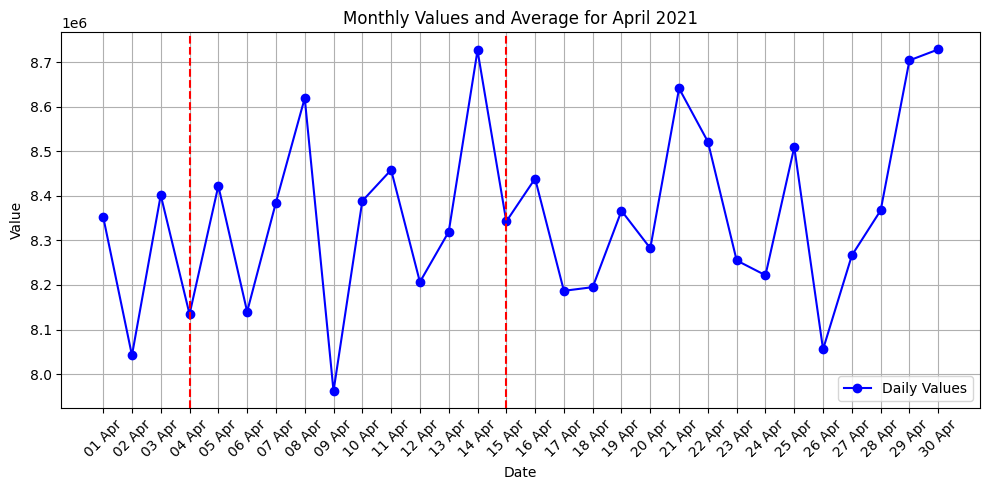

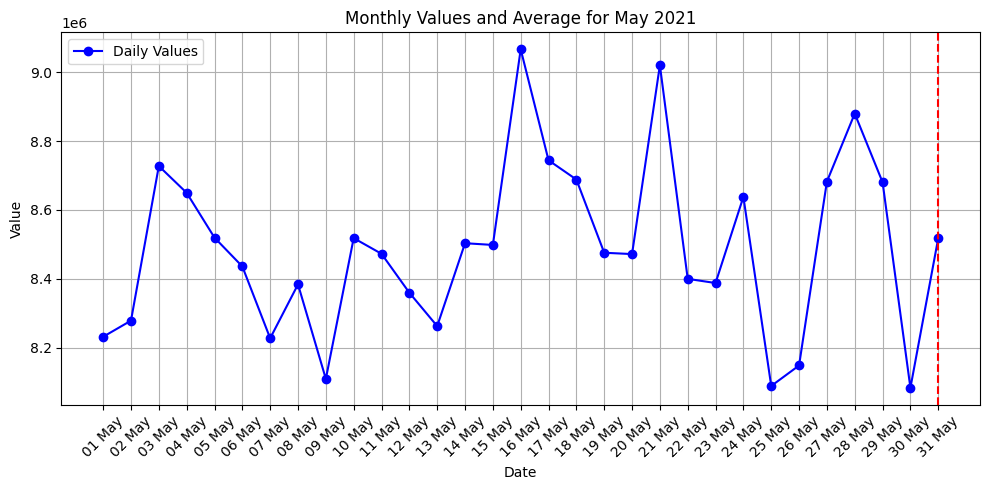

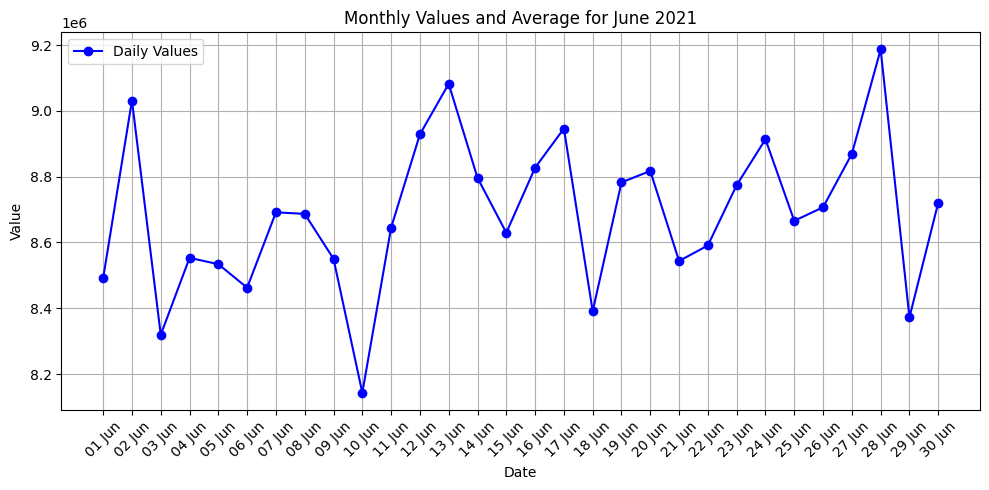

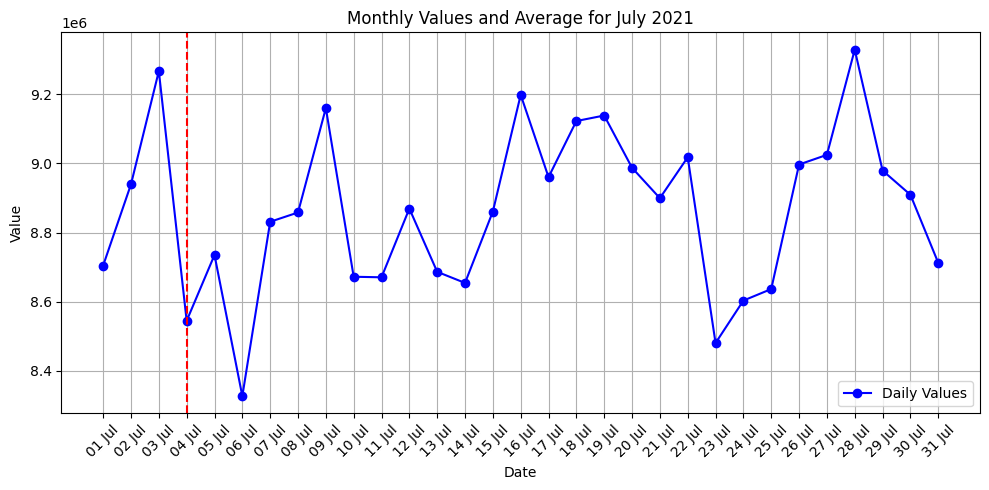

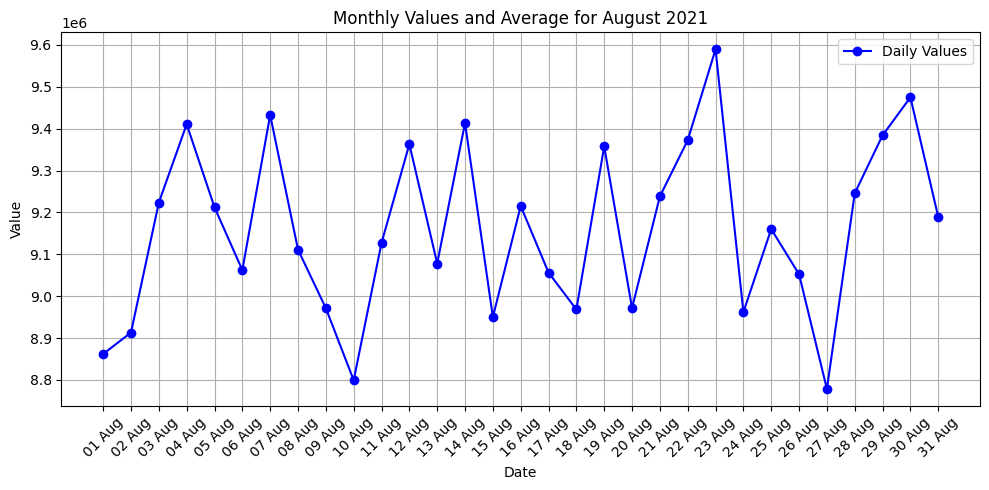

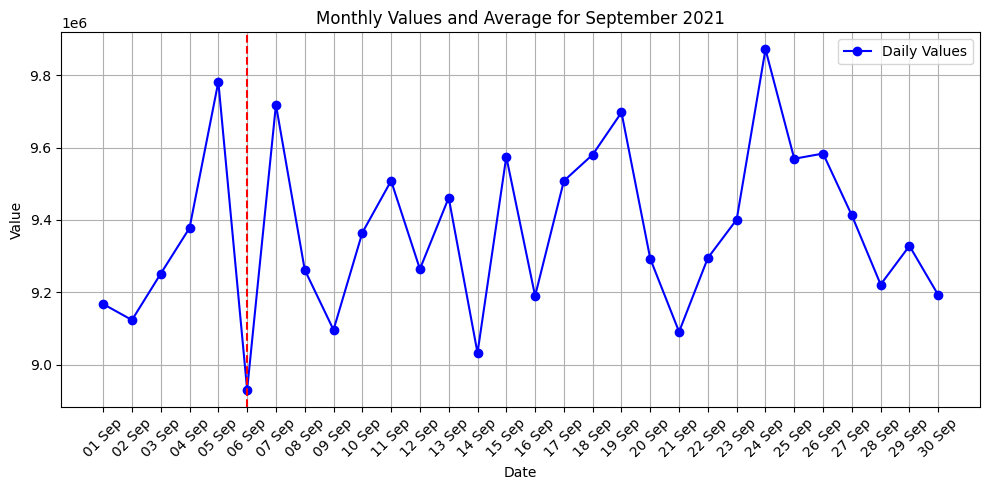

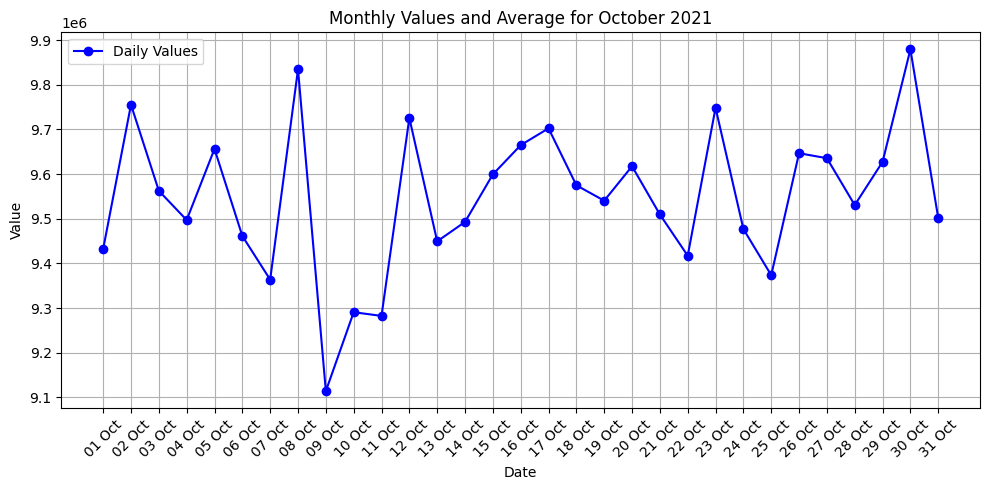

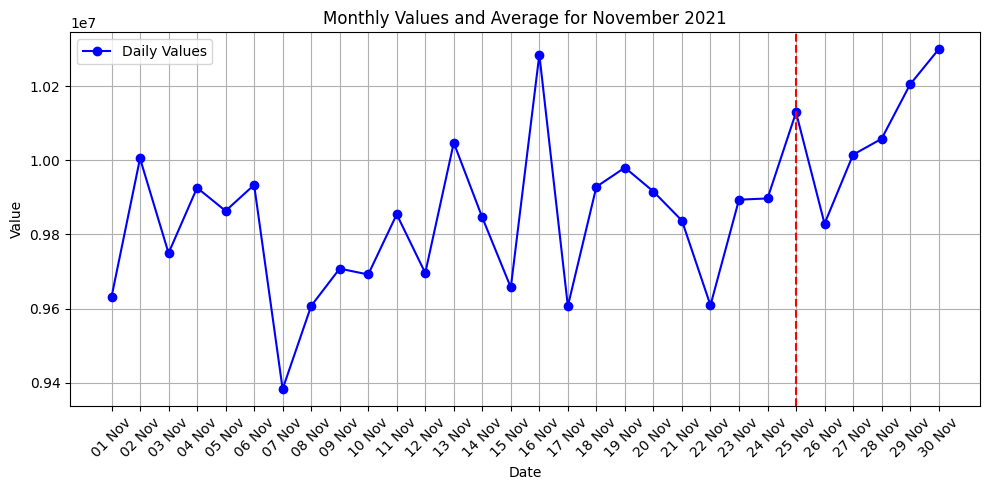

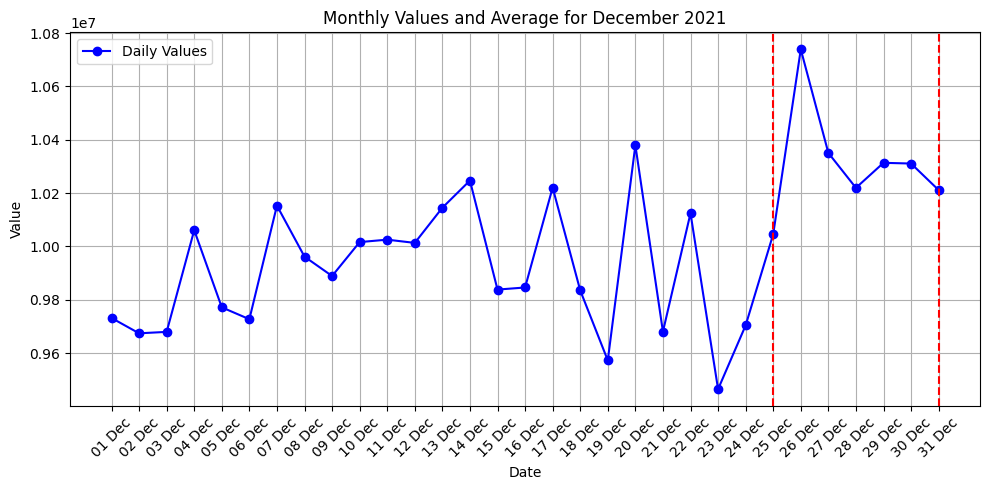

In [145]:
df.set_index('# Date', inplace=True)
for month in range(1, 13):
    monthly_data = df[df.index.month == month]

    # Create a new figure for the current month
    plt.figure(figsize=(10, 5))

    plt.plot(monthly_data.index, monthly_data['Receipt_Count'], marker='o', linestyle='-', color='b', label='Daily Values')

    for holiday_date in monthly_data[monthly_data['Holiday_Match']].index:
        plt.axvline(holiday_date, color='red', linestyle='--')

    # Set titles and labels
    plt.title(f'Monthly Values and Average for {monthly_data.index[0].strftime("%B %Y")}')
    plt.xlabel('Date')
    plt.ylabel('Value')

    # Formatting x-ticks to show day
    plt.xticks(monthly_data.index, monthly_data.index.strftime('%d %b'), rotation=45)

    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

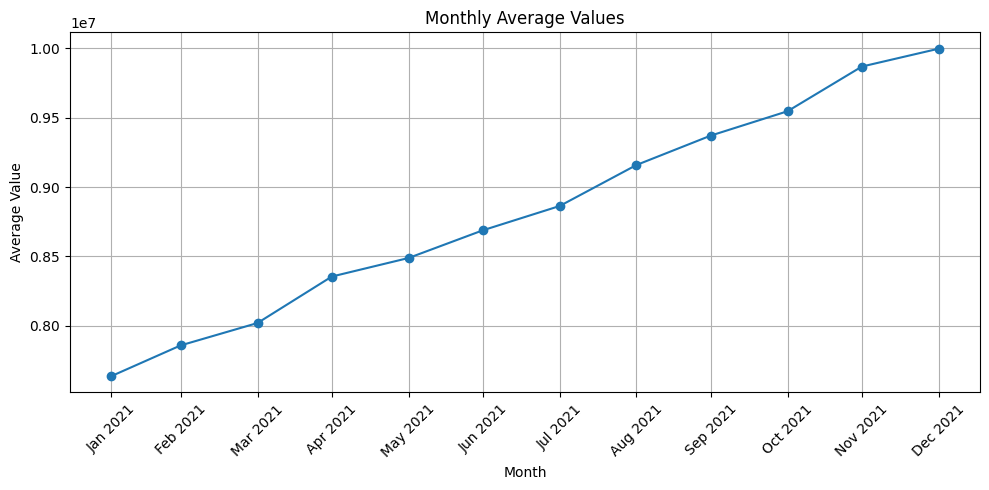

In [146]:
df = pd.read_csv('/content/data_daily.csv')
df['# Date'] = pd.to_datetime(df['# Date'])
df.set_index('# Date', inplace=True)
monthly_average = df.resample('ME').mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_average.index, monthly_average['Receipt_Count'], marker='o', linestyle='-')
plt.title('Monthly Average Values')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(monthly_average.index, monthly_average.index.strftime('%b %Y'), rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

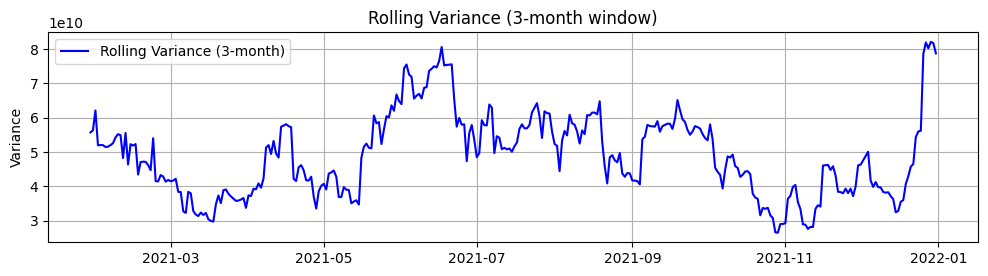

In [147]:
# Plot rolling variance
rolling_variance = df['Receipt_Count'].rolling(window=28).var()

monthly_variance = df.resample('ME').var()

plt.figure(figsize=(12, 6))


plt.subplot(2, 1, 1)
plt.plot(rolling_variance.index, rolling_variance, color='blue', label='Rolling Variance (3-month)')
plt.title('Rolling Variance (3-month window)')
plt.ylabel('Variance')
plt.grid(True)
plt.legend()

In [148]:
result = adfuller(df['Receipt_Count'])

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}: {value}")

# Non stationary conclusion

ADF Statistic: 0.1750441657200558
p-value: 0.9708266454651425
Critical Values:
    1%: -3.449336554273722
    5%: -2.8699055166063085
    10%: -2.571226758215748


In [149]:
# Least Squares test
dates_ordinal = np.array([d.toordinal() for d in df.index])

# Get the receipt counts as a NumPy array
y = df['Receipt_Count'].to_numpy()

X = dates_ordinal.reshape(-1, 1)

def leastsquares_fit(p, a, b):
    # form a based on p
    x = np.hstack([a ** i for i in range(p+1)])

    w_opt = np.linalg.inv(x.T@x) @ x.T @b

    return w_opt

w_opt_LS = leastsquares_fit(1, X, y)
print(w_opt_LS)

[-5.24559136e+09  7.12006798e+03]


Root Mean Squared Error (RMSE): 216892.79099449873


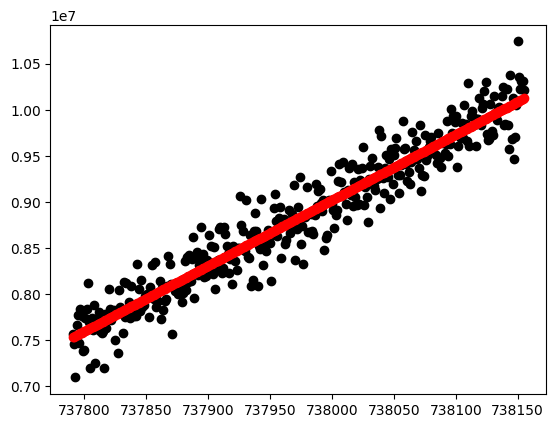

In [150]:
# Plot predictions
n_train = len(X)

x_train_LS = np.hstack((np.ones((n_train,1)), X))
y_hat_LS = x_train_LS@w_opt_LS

plt.scatter(X, y, label='Original Data', color='black')
plt.scatter(X, y_hat_LS, label=f'Fit: p={1}', color='Red')

rmse_LS = np.sqrt(np.mean((y_hat_LS - y) ** 2))

print("Root Mean Squared Error (RMSE):", rmse_LS)

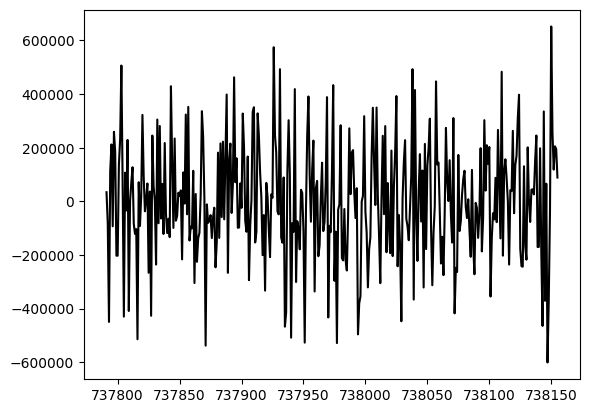

In [151]:
# Plot data-predictions
diff_from_ls=y-y_hat_LS
plt.plot(X, diff_from_ls, label='Original Data', color='black')

# looks like Gaussian noise

In [152]:
result = adfuller(diff_from_ls)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"    {key}: {value}")

# Stationary conclusion
mean = np.mean(diff_from_ls)
print(f"mean: {mean}")

# zero mean probably white noise

ADF Statistic: -12.6116311275782
p-value: 1.650439265240456e-23
Critical Values:
    1%: -3.448544133483233
    5%: -2.8695574079525565
    10%: -2.5710411593052713
mean: 0.012672635953720302


In [159]:
# going to use cross validation to reduce the white noise using ridge regression
def ridge(X, y, lam):
  # closed for solution for ridge:AT(AAT + lamI)^-1 y
  n_features = X.shape[0]
  I = np.eye(n_features)

  Xt = X.T

  inner_part = np.linalg.inv(X@Xt + lam * I)

  w_ridge = Xt@ inner_part @ y

  return w_ridge

# function to find 5 fold on a given lambda
def perform_cross_validation(X, y, lambda_values, num_folds=5):
    # To accumulate RMSE values for each lambda
    rmse_cross = [0] * len(lambda_values)

    # Iterate over all folds
    for val_index in range(num_folds):
        # set indices
        val_idx = np.arange(val_index * (len(X) // num_folds), (val_index + 1) * (len(X) // num_folds))

        # Determine training/test set
        train_idx = np.setdiff1d(np.arange(len(X)), val_idx)
        X_train, y_train = X[train_idx, :], y[train_idx]
        X_val, y_val = X[val_idx, :], y[val_idx]

        # Loop through each lambda value for Ridge Regression
        for i, lam in enumerate(lambda_values):
            w_ridge = ridge(X_train, y_train, lam)

            y_pred_val = X_val @ w_ridge

            # Compute RMSE for the current fold and lambda
            rmse = np.sqrt(np.mean((y_val - y_pred_val) ** 2))

            # Accumulate RMSE for this lambda
            rmse_cross[i] += rmse

    # Compute average RMSE across all folds for each lambda
    rmse_cross = [rmse / num_folds for rmse in rmse_cross]

    return rmse_cross

# get data again
dates_ordinal = np.array([d.toordinal() for d in df.index])

# Get the values
dates_ordinal = np.array([d.toordinal() for d in df.index])
y = df['Receipt_Count'].to_numpy()

X = dates_ordinal.reshape(-1, 1)
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_normalized = (X - X_min) / (X_max - X_min)
x_train_ones = np.hstack((np.ones((n_train,1)), X_normalized))

# create a list of lambda values
lambda_values = np.log10(np.logspace(1e-6, 20, num=500))

rmse = perform_cross_validation(x_train_ones, y, lambda_values, num_folds=5)

In [160]:
print(rmse)

[217270.29629131826, 217320.9955828741, 217387.2666398609, 217468.85422287704, 217565.49992705416, 217676.94154981407, 217802.91370688722, 217943.14843927947, 218097.37580838427, 218265.32447535, 218446.72226179438, 218641.29668941133, 218848.77549577522, 219068.8871250432, 219301.3611914246, 219545.9289148342, 219802.32352750353, 220070.28065135702, 220349.53864571723, 220639.83892581202, 220940.9262518424, 221252.548989701, 221574.45934368932, 221906.41356238085, 222248.17211835406, 222599.49986325548, 222960.16615906832, 223329.94498708882, 223708.61503582896, 224095.95976902143, 224491.76747546633, 224895.83130156985, 225307.94926823844, 225727.92427322883, 226155.56408028174, 226590.68129624767, 227033.09333729194, 227482.62238535145, 227939.09533586857, 228402.34373779307, 228872.20372675505, 229348.51595232048, 229831.12550014205, 230319.88180972426, 230814.63858849672, 231315.25372293015, 231821.58918713336, 232333.51094960113, 232850.88887860352, 233373.59664647415, 233901.511